In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
from PIL import Image
import kagglehub
from dreamsim import dreamsim
from math import log10, sqrt
import cv2 as cv
import pickle

In [15]:
# Download latest version
# path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

# print("Path to dataset files:", path)

# if os.path.isfile(path):
#     print("file")

# Download latest version
path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.82G/1.82G [00:46<00:00, 42.2MB/s]

Extracting files...


Path to dataset files: C:\Users\Jen\.cache\kagglehub\datasets\eduardo4jesus\stanford-cars-dataset\versions\1


In [2]:
x = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]).float()
print(x)
new = torch.softmax(x, dim=0)
print(new)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([0.0744, 0.0744, 0.2023, 0.0744, 0.0744, 0.0744, 0.0744, 0.0744, 0.2023,
        0.0744])


In [3]:
def showImage(image):
    tensor_normalized = (image - image.min()) / (image.max() - image.min())
    plt.imshow(tensor_normalized)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [4]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        print("No noise present in the compared images")
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [5]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cuda


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     (0.5, 0.5, 0.5),
    #     (0.5, 0.5, 0.5)
    # )
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# test_set_cars = torchvision.datasets.StanfordCars(root='./data', split='test', target_transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(train_loader.dataset[0])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:11<00:00, 14.9MB/s]


(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

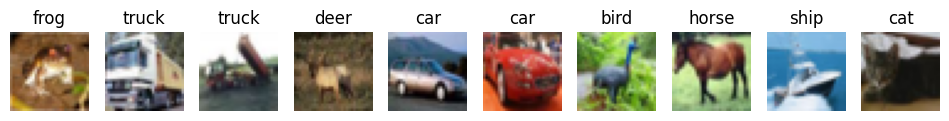

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    # denormalized_image= image / 2 + 0.5
    axes[i].imshow(image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [8]:
class ConvNeuralNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(1) # to work with variable image sizes

        # self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc1 = nn.Linear(128, 120) # because output of self.gap is [batch, 128, 1, 1]
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.gap(x) # to work with variable image sizes
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.softmax(self.fc3(x), dim=1)
        # print(x)
        return x

net = ConvNeuralNet()
net.to(device)
PATH = './cifar_net_variable_image_sizes.pth'

In [9]:
if os.path.isfile(PATH):
    net.load_state_dict(torch.load(PATH, weights_only=True))
    print("existing model loaded")
    
    # for i, data in enumerate(train_loader):
    #     inputs, labels = data[0].to(device), data[1].to(device)
    #     print(inputs.shape)
else:
    print("no existing model found. Initiating training\n")
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    epochs = 10
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            if i == 0:
                print(labels)
                print(outputs)
            
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), PATH)

existing model loaded


In [10]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    # denormalized_image= image / 2 + 0.5
    ax1.imshow(image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

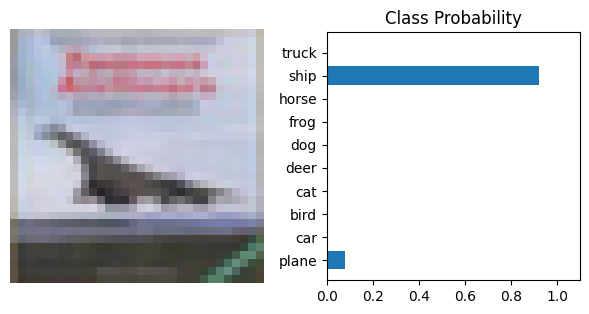

In [11]:
images, _ = next(iter(test_loader))

image = images[3]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)
    probabilities = torch.softmax(log_probabilities, dim=1)

probabilities = probabilities.squeeze().cpu()
view_classification(image, probabilities)

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # print(labels)

        outputs = net(images)
        # print(outputs)

        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print(correct)
        # print()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [63]:
carDatasetDir = r"C:\Users\Jen\.cache\kagglehub\datasets\eduardo4jesus\stanford-cars-dataset\versions\1\cars_test\cars_test"

carIndices = []
carDataset = []
remake = True

if os.path.isfile('./carDataset.pkl') and not remake:

    print("Found loaded car dataset")
    with open('carDataset.pkl', 'rb') as f:
        carDataset = pickle.load(f)

else:

    print("No dataset found, checking if there is an index list")

    if os.path.isfile('./carIndices.pkl'):
        
        print("Found an existing list of car indices, now reading file")
        with open('carIndices.pkl', 'rb') as f:
            carIndices = pickle.load(f)
            
    else:
    
        print("No existing list of car indices found, now making it")
    
        for idx, filename in enumerate(os.listdir(carDatasetDir)):
            # print(f"Now starting on image {idx + 1}")
            filepath = os.path.join(carDatasetDir, filename)
            if os.path.isfile(filepath):
                carImage = Image.open(filepath)
                carTensor = torchvision.transforms.functional.pil_to_tensor(carImage)
                carTensor = carTensor.float()
                carTensor = carTensor.to(device)
        
                if carTensor.shape[0] == 3:  # Meaning we're working with an RGB image
                
                    # print(filename)
                    # print(filepath)
                    # print(carTensor)
                    # print(carTensor.shape)
                    # print(f"Image {idx+1} has a shape of {carTensor.shape[0]}")
                    output = net(carTensor.unsqueeze(0))
                    probabilities = torch.softmax(output, dim=1).squeeze()
                    predictionTensor = torch.argmax(probabilities)
                    predictionInt = predictionTensor.item()
                    if predictionInt == 1:
                        print(f"Image {idx + 1} got labeled as {classes[predictionInt]}")
                        carIndices.append(idx)
    
        with open('carIndices.pkl', 'wb') as f:
            pickle.dump(carIndices, f)
    
    print("Now using index list to create dataset")
    
    for idx, filename in enumerate(os.listdir(carDatasetDir)):
    
        filepath = os.path.join(carDatasetDir, filename)
        if os.path.isfile(filepath):
            carImage = Image.open(filepath)
            carTensor = torchvision.transforms.functional.pil_to_tensor(carImage)
            carTensor = carTensor.float()
            carDataset.append(carTensor)

    with open('carDataset.pkl', 'wb') as f:
        pickle.dump(carDataset, f)

No dataset found, checking if there is an index list
Found an existing list of car indices, now reading file
Now using index list to create dataset


OSError: [Errno 28] No space left on device

tensor([[[253.9865, 253.5203, 253.4554,  ..., 254.0741, 254.0000, 254.0000],
         [254.1301, 254.3679, 254.0814,  ..., 254.1380, 254.0000, 254.0000],
         [254.3539, 254.7597, 255.5050,  ..., 253.2295, 254.0000, 254.0000],
         ...,
         [253.7005, 253.9436, 254.2251,  ..., 254.0735, 254.0000, 254.0000],
         [253.8727, 253.9383, 253.9541,  ..., 254.0097, 254.0000, 254.0000],
         [253.8026, 254.0152, 253.7163,  ..., 254.0203, 254.0000, 254.0000]],

        [[254.0343, 254.1691, 253.6495,  ..., 254.0793, 254.0000, 254.0000],
         [253.9707, 253.6250, 253.4634,  ..., 254.0715, 254.0000, 254.0000],
         [253.9541, 254.0466, 253.1739,  ..., 253.4875, 254.0000, 254.0000],
         ...,
         [254.4743, 254.0672, 253.6887,  ..., 254.1668, 254.0000, 254.0000],
         [254.2291, 254.0710, 253.9157,  ..., 254.0089, 254.0000, 254.0000],
         [254.1512, 254.1623, 253.5231,  ..., 254.0409, 254.0000, 254.0000]],

        [[253.9131, 253.4047, 253.3267,  ...

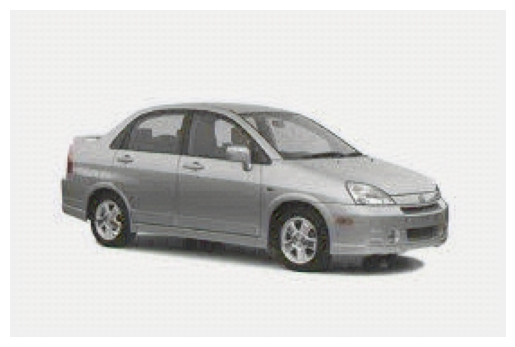

In [61]:
print(carDataset[0])
showImage(carDataset[0].cpu().permute(1, 2, 0))

In [13]:
# Freeze all the parameters in the network
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [14]:
'''
With a higher res image
'''

pilimage = Image.open('boat.jpg')
pilimage.show()
# tensorpilimage = transform(pilimage)
# print(tensorpilimage.shape)
# showImage(tensorpilimage.permute(1, 2, 0))


Now going to next image


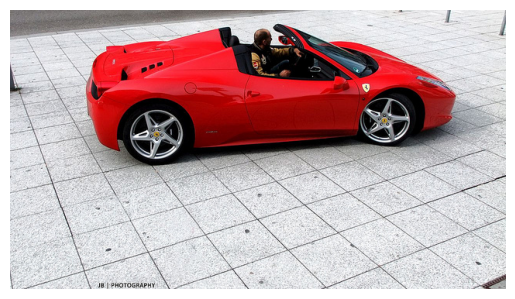

car
ship
plane
plane
plane
plane
car
car
car
car
bird
plane
plane
dog
dog
dog
plane
bird
frog

Optimized image labled as frog:


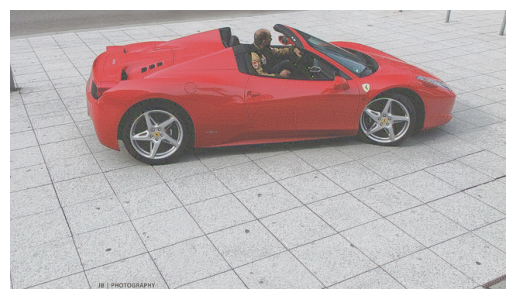


Noise between original and optimized:


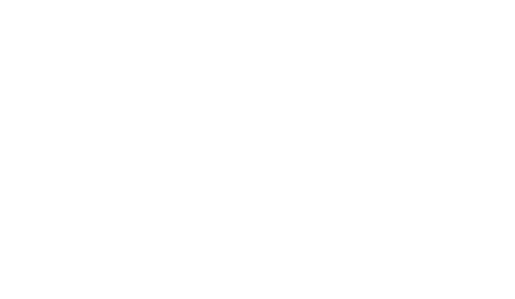

In [74]:

label = torch.tensor([6]).to(device)
x = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]).float().to(device)

totalPSNR = 0.0
amountSamples = 0

noiseList = []

# for im in carDataset:
# for im in test_loader.dataset:
print()
print("Now going to next image")
# original_img = im[0]
# original_img = im
# showImage(original_img.cpu().permute(1, 2, 0))
# original_img = tensorpilimage
original_img = torchvision.transforms.functional.pil_to_tensor(Image.open(os.path.join(carDatasetDir, '00002.jpg'))).float()
showImage(original_img.cpu().permute(1, 2, 0))
original_img = original_img.to(device)

img = original_img.to(device)
img = img.unsqueeze(0)
img = img.requires_grad_(True)

# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()
loss_function2 = nn.MSELoss()
sigmoid = nn.Sigmoid()

experimentOptimizer = torch.optim.SGD([img], lr=1000.0, momentum=0.7)

predictedClass = -1

# for _ in range(500):
# if im[1] != 6:
while predictedClass != label.item():
# while probabilities2[2] != max(probabilities2) and probabilities2[2] != 0:
    experimentOptimizer.zero_grad()

    output = net(img)

    # probabilities = torch.softmax(output, dim=1).squeeze().cpu()

    probabilities = torch.softmax(output, dim=1).squeeze()
    # probabilities2 = probabilities
    predictionTensor = torch.argmax(probabilities)
    predictionInt = predictionTensor.item()
    predictedClass = predictionInt
    print(classes[predictionInt])

    # celoss = loss_function(probabilities, x)
    celoss = loss_function(output, label)
    # lossimg = original_img.unsqueeze(0) - img
    # maxval = torch.max(lossimg)
    l1loss = loss_function2(original_img.unsqueeze(0), img)
    loss = celoss + l1loss

    celoss.backward()
    experimentOptimizer.step()

print()
print("Optimized image labled as frog:")
showImage(img.squeeze().detach().cpu().permute(1, 2, 0))

noise = original_img.cpu() - img.squeeze().detach().cpu()
noise = torch.abs(noise)
noise[noise <= 0.0004] = 1

print()
print("Noise between original and optimized:")
showImage(sigmoid(noise).permute(1, 2, 0))

#     noiseList.append(noise)

#     numpy_image = im[0].numpy()
#     # print("numpy image:")
#     # showImage(np.transpose(numpy_image, (1, 2, 0)))
#     cv_image = np.transpose(numpy_image, (1, 2, 0))
#     cv_image = cv.cvtColor(cv_image, cv.COLOR_BGR2RGB)

#     numpy_image2 = img.squeeze().detach().cpu().numpy()
#     # print("numpy optimized image image:")
#     # showImage(np.transpose(numpy_image2, (1, 2, 0)))
#     cv_image2 = np.transpose(numpy_image2, (1, 2, 0))
#     cv_image2 = cv.cvtColor(cv_image2, cv.COLOR_BGR2RGB)
    
#     val = PSNR(cv_image, cv_image2)
#     print(val)
#     print()

#     totalPSNR += val
#     amountSamples += 1

# if amountSamples == 10:
#     break

# print(f"Average PSNR over {amountSamples} samples is {totalPSNR / amountSamples}")

# stacked_noise = torch.stack(noiseList, dim=0)
# print("shape of stacked noise:", stacked_noise.shape)
# average_noise = torch.mean(stacked_noise, dim=0)
# showImage(average_noise.permute(1, 2, 0))

# amountSamples2 = 0

# for im in test_loader.dataset:
#     if im[1] != 6:
#         amountSamples2 += 1
#         testimage = im[0] + average_noise
#         output2 = net(testimage.unsqueeze(0).to(device))
#         probabilities = torch.softmax(output2, dim=1).squeeze()
#         predictionTensor = torch.argmax(probabilities)
#         predictionInt = predictionTensor.item()
#         predictedClass = predictionInt

#         print()
#         print("Image with average noise added:")
#         showImage(testimage.permute(1, 2, 0))
#         print("Predicted class:", classes[predictionInt])

#     if amountSamples2 == 10:
#         break

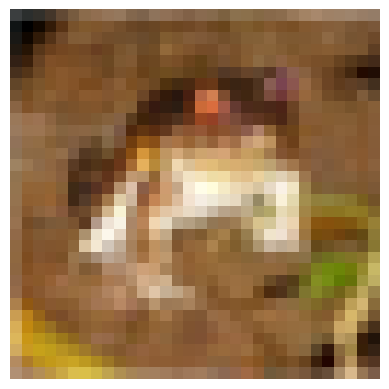

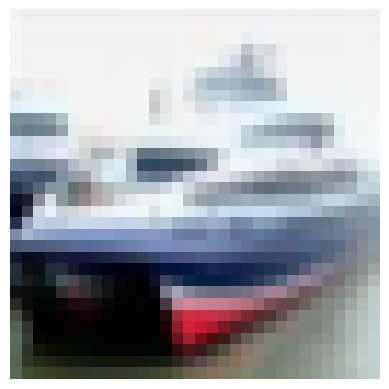

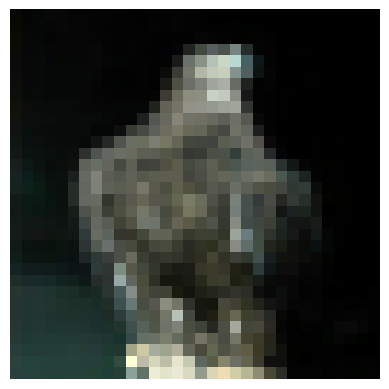

tensor([[[ 0.9059,  0.8980,  0.8980,  ...,  0.9138,  0.9137,  0.9098],
         [ 0.9137,  0.9098,  0.9136,  ...,  0.9255,  0.9255,  0.9216],
         [ 0.9019,  0.9021,  0.9099,  ...,  0.9216,  0.9216,  0.9176],
         ...,
         [ 0.2432,  0.0862, -0.0118,  ...,  0.6627,  0.7137,  0.7373],
         [ 0.2157,  0.0902,  0.0510,  ...,  0.6784,  0.7216,  0.7294],
         [ 0.2275,  0.1490,  0.1333,  ...,  0.6549,  0.7020,  0.7216]],

        [[ 0.9059,  0.8980,  0.8940,  ...,  0.9137,  0.9137,  0.9098],
         [ 0.9137,  0.9098,  0.9058,  ...,  0.9255,  0.9255,  0.9216],
         [ 0.9059,  0.9021,  0.9022,  ...,  0.9216,  0.9216,  0.9176],
         ...,
         [ 0.2392,  0.0509, -0.0589,  ...,  0.7216,  0.7725,  0.7922],
         [ 0.2157,  0.0627,  0.0118,  ...,  0.7373,  0.7804,  0.7882],
         [ 0.2392,  0.1373,  0.1020,  ...,  0.7137,  0.7569,  0.7765]],

        [[ 0.9137,  0.8980,  0.8941,  ...,  0.9136,  0.9137,  0.9098],
         [ 0.9216,  0.9098,  0.9098,  ...,  0

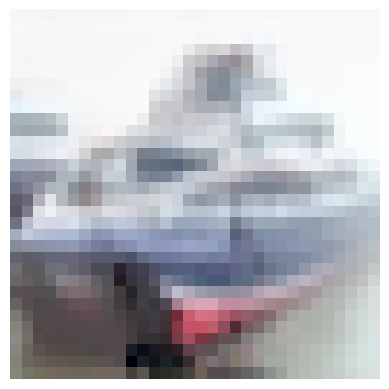

following images has been converted to a frog:
PSNR value: 52.25152736320198


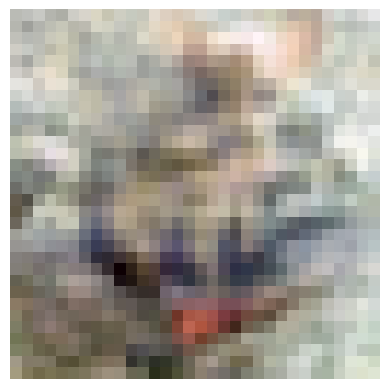

0.06


In [17]:
image = test_loader.dataset[1][0]

otherTestImage = train_loader.dataset[0][0]
showImage(otherTestImage.permute(1, 2, 0))
# image = tensorpilimage
# denormalized_image= image / 2 + 0.5

showImage(image.permute(1, 2, 0))
showImage(img.squeeze().detach().permute(1, 2, 0).cpu())

diff = image - img.squeeze().detach().cpu()
# diff = torch.abs(diff)
# diff[diff <= 0.0004] = 1
# diff *= 10000
print(diff)

showImage(diff.permute(1, 2, 0))


# dreamsimModel, preprocess = dreamsim(pretrained=True, cache_dir="/home/jv/.cache")

# pilTransform = transforms.ToPILImage()

# pilimage1 = pilTransform(image)
# pilimage2 = pilTransform(otherTestImage)

# asldkf = pilTransform(image)
# asldkf.show()

# dreamsimImage1 = preprocess(Image.open("cifarboat.jpg"))
# dreamsimImage2 = preprocess(Image.open("cifarfrog.jpg"))

# dreamsimImage1 = dreamsimImage1.to(device)
# dreamsimImage2 = dreamsimImage2.to(device)

# distance = dreamsimModel(dreamsimImage1, dreamsimImage1)
# print()
# print("DISTANCE:", distance)
# print()

# original_images = []
# images2 = []

count = 0

for im in test_loader.dataset:
    # original_image = im[0]
    # original_image = original_image.to(device)
    # original_images.append(original_image)

    # image2 = im[0].to(device)
    # image2 = image2.unsqueeze(0)
    # image2 = image2.requires_grad_(True)
    # images2.append(image2)

    label2 = im[1]
    new = im[0] + diff
    output = net(new.unsqueeze(0).to(device))

    # probabilities = torch.softmax(output, dim=1).squeeze().cpu()
    # print(classes[torch.argmax(probabilities).item()])
    # print(output)
    # print(label)

    probabilities = torch.softmax(output, dim=1).squeeze()
    # probabilities2 = probabilities
    # print(probabilities)
    predictionTensor = torch.argmax(probabilities)
    predictionInt = predictionTensor.item()
    if predictionInt == 6:
        count += 1
        if label2 != 6:
            print("following images has been converted to a frog:")
            print("PSNR value:", PSNR(cv.cvtColor(np.transpose(im[0].numpy(), (1, 2, 0)), cv.COLOR_BGR2RGB), cv.cvtColor(np.transpose(new.numpy(), (1, 2, 0)), cv.COLOR_BGR2RGB)))
            showImage(new.permute(1, 2, 0))
        # if label2.
    # predictedClass = predictionInt
    # print(classes[predictionInt])

print((count/len(test_loader.dataset))*100)

# showImage(test_loader.dataset[6][0].permute(1, 2, 0))
# showImage(new.permute(1, 2, 0))



# new_img = test_loader.dataset[126][0]
# new_img += diff

# output = net(new_img.to(device).unsqueeze(0))

# probabilities = torch.softmax(output, dim=1)
# predictionTensor = torch.argmax(probabilities)
# predictionInt = predictionTensor.item()
# predictedClass = predictionInt
# print(classes[predictionInt])

# reconstructed_img = torch.stack(iterable_of_tensors, dim = 0)

# mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(3, 1, 1)
# reconstructed_img2 = reconstructed_img / 2 + 0.5  # Reverse normalization
# output = net(reconstructed_img.unsqueeze(0))
# print(reconstructed_img)


# Clip to valid range [0, 1] (for visualization)
# reconstructed_img2 = torch.clamp(reconstructed_img2, 0, 1)

# probabilities = torch.softmax(output, dim=1).squeeze().cpu()
# print(probabilities.sum())
# print(classes[torch.argmax(probabilities).item()])

# # Convert to NumPy and permute dimensions for matplotlib (H × W × C)
# img_np = reconstructed_img2.detach().cpu().numpy().transpose(1, 2, 0)

# # Visualize
# plt.imshow(img)
# plt.axis('off')  # Hide axes
# plt.show()

# # Visualize
# plt.imshow(img_np)
# plt.axis('off')  # Hide axes
# plt.show()